## Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib.occupancy import compute_occupancy, estimate_rate_occupancy

# Paths
fails_path_run3 = "1_data/df3_valid.csv"
beam_path_run3 = "1_data/beam3.csv"
fails_path_run2 = "1_data/df2_valid.csv"
beam_path_run2 = "1_data/beam2.csv"

def load_and_prep_data(fails_path, beam_path):
    print(f"Loading {fails_path} and {beam_path}...")
    fails = pd.read_csv(fails_path)
    beam = pd.read_csv(beam_path)
    
    # Convert time columns
    fails['time'] = pd.to_datetime(fails['time'])
    beam['time'] = pd.to_datetime(beam['time'])
    
    # Sort
    fails = fails.sort_values('time')
    beam = beam.sort_values('time')
    
    # Ensure beam_on is boolean
    beam['beam_on'] = beam['beam_on'].astype(bool)
    
    return fails, beam

# Load Run 3 data initially for the demo analysis
fails, beam = load_and_prep_data(fails_path_run3, beam_path_run3)
print(f"Loaded {len(fails)} fails and {len(beam)} beam records.")

Loading 1_data/df3_valid.csv and 1_data/beam3.csv...
Loaded 1081006 fails and 9997 beam records.


## 1. Merge and Filter (Beam ON)

We merge the fails data with the beam data to filter for periods where the beam is active.

In [2]:
# Merge fails with beam data (backward search to find the latest beam status)
fails_merged = pd.merge_asof(fails, beam[['time', 'beam_on']], on='time', direction='backward')

# Filter for Beam ON
fails_on = fails_merged[fails_merged['beam_on'] == True].copy()

print(f"Fails total: {len(fails)}")
print(f"Fails with Beam ON: {len(fails_on)}")

Fails total: 1081006
Fails with Beam ON: 1070425


## 2. Identify High and Low Activity Regions

We calculate a rolling mean of failures to identify regions of high and low activity *within the beam-on periods*.

In [3]:
# Calculate rolling mean of fails (window=1000)
fails_on['rolling_fails'] = fails_on['fails_inst'].rolling(window=1000).mean()

# --- High Rate Region ---
# Find peak activity
high_activity_idx = fails_on['rolling_fails'].idxmax()
high_center_time = fails_on.loc[high_activity_idx, 'time']

# Select +/- 5 minutes around peak
high_rate_segment = fails_on[(fails_on['time'] >= high_center_time - pd.Timedelta(minutes=5)) & 
                             (fails_on['time'] <= high_center_time + pd.Timedelta(minutes=5))]

# --- Low Rate Region ---
# Find minimum activity among NON-ZERO values
# We filter for rolling_fails > 0 to ensure we don't pick a region with 0 errors
non_zero_fails = fails_on[fails_on['rolling_fails'] > 0]

if len(non_zero_fails) > 0:
    low_activity_idx = non_zero_fails['rolling_fails'].idxmin()
    low_center_time = fails_on.loc[low_activity_idx, 'time']
else:
    print("Warning: No non-zero rolling fails found. Defaulting to overall minimum.")
    low_activity_idx = fails_on['rolling_fails'].dropna().idxmin()
    low_center_time = fails_on.loc[low_activity_idx, 'time']

# Select +/- 5 minutes around minimum
low_rate_segment = fails_on[(fails_on['time'] >= low_center_time - pd.Timedelta(minutes=5)) & 
                            (fails_on['time'] <= low_center_time + pd.Timedelta(minutes=5))]

# Check if we actually have fails
if low_rate_segment['fails_inst'].sum() == 0:
    print("Warning: Selected Low Rate segment has 0 fails. Trying to find a better region...")
    # Fallback: Find the window with the smallest non-zero sum of fails
    # This is computationally more expensive but safer
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=1000) # Approx window
    fails_on['rolling_sum'] = fails_on['fails_inst'].rolling(window=indexer, min_periods=1).sum()
    
    # Filter for sum > 0
    non_zero_sums = fails_on[fails_on['rolling_sum'] > 0]
    if len(non_zero_sums) > 0:
        best_idx = non_zero_sums['rolling_sum'].idxmin()
        low_center_time = fails_on.loc[best_idx, 'time']
        low_rate_segment = fails_on[(fails_on['time'] >= low_center_time - pd.Timedelta(minutes=5)) & 
                                    (fails_on['time'] <= low_center_time + pd.Timedelta(minutes=5))]

print(f"High Rate Center: {high_center_time}, Samples: {len(high_rate_segment)}")
print(f"Low Rate Center: {low_center_time}, Samples: {len(low_rate_segment)}, Total Fails: {low_rate_segment['fails_inst'].sum()}")

High Rate Center: 2022-11-12 16:11:32.532970, Samples: 665
Low Rate Center: 2022-11-09 15:28:26.775331, Samples: 561, Total Fails: 12


## 3. Analysis Function

Helper function to compute rates.

In [4]:
def compare_rates(df_segment, window_size_s):
    if len(df_segment) == 0:
        return {'lambda_naive': np.nan, 'lambda_hat': np.nan, 'phi': np.nan}
        
    # Compute occupancy
    occ = compute_occupancy(df_segment, time_col='time', signal_col='fails_inst', window_size_s=window_size_s)
    
    # Estimate rates
    res = estimate_rate_occupancy(occ, window_size_s=window_size_s)
    
    return res

## 4. Compare Estimators

We calculate rates for both segments using a fixed window $T=0.1s$.

In [5]:
T = 0.1 # 100ms window

res_low = compare_rates(low_rate_segment, T)
res_high = compare_rates(high_rate_segment, T)

print("--- Low Rate Regime (Beam ON) ---")
print(f"Naive:     {res_low['lambda_naive']:.4f} Hz")
print(f"Corrected: {res_low['lambda_hat']:.4f} Hz")
print(f"Occupancy: {res_low['phi']:.2%}")

print("\n--- High Rate Regime (Beam ON) ---")
print(f"Naive:     {res_high['lambda_naive']:.4f} Hz")
print(f"Corrected: {res_high['lambda_hat']:.4f} Hz")
print(f"Occupancy: {res_high['phi']:.2%}")

--- Low Rate Regime (Beam ON) ---
Naive:     0.0334 Hz
Corrected: 0.0334 Hz
Occupancy: 0.33%

--- High Rate Regime (Beam ON) ---
Naive:     1.9661 Hz
Corrected: 2.1891 Hz
Occupancy: 19.66%


## 5. Rate vs Window Size

Analyze stability of the estimators across different window sizes.

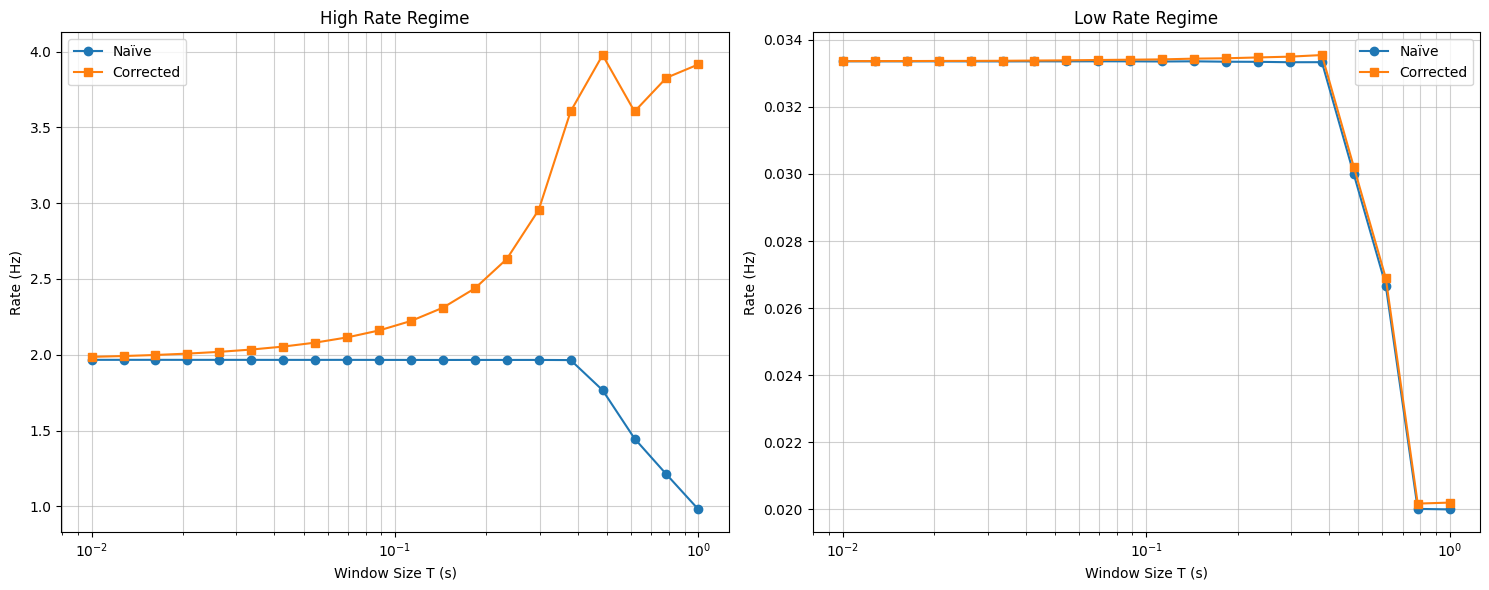

In [6]:
windows = np.logspace(-2, 0, 20) # 10ms to 1s

def get_rate_curve(segment):
    naive = []
    corrected = []
    for w in windows:
        r = compare_rates(segment, w)
        naive.append(r['lambda_naive'])
        corrected.append(r['lambda_hat'])
    return naive, corrected

naive_high, corr_high = get_rate_curve(high_rate_segment)
naive_low, corr_low = get_rate_curve(low_rate_segment)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# High Rate Plot
ax1.semilogx(windows, naive_high, 'o-', label='Naïve')
ax1.semilogx(windows, corr_high, 's-', label='Corrected')
ax1.set_title('High Rate Regime')
ax1.set_xlabel('Window Size T (s)')
ax1.set_ylabel('Rate (Hz)')
ax1.legend()
ax1.grid(True, which="both", ls="-", alpha=0.6)

# Low Rate Plot
ax2.semilogx(windows, naive_low, 'o-', label='Naïve')
ax2.semilogx(windows, corr_low, 's-', label='Corrected')
ax2.set_title('Low Rate Regime')
ax2.set_xlabel('Window Size T (s)')
ax2.set_ylabel('Rate (Hz)')
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.6)

plt.tight_layout()
plt.show()

# Phase 1 & 2: Metrics Calculation

We now calculate the full metrics for Run 2 and Run 3.

**Metrics:**
*   **N (Corrected)**: Total failures estimated using the corrected rate model.
*   **$\Phi$ (Fluence)**: Total High Energy Hadron (HEH) fluence during Beam ON periods.
*   **Cross Section ($\sigma$)**: $\sigma = N / \Phi$
*   **Failure Rate ($\lambda$)**: $\lambda = N / \text{Time}_{ON}$
*   **MTBF**: $1 / \lambda$
*   **Reliability**: $R(t) = e^{-\lambda t}$


--- Processing Run 2 ---
Loading 1_data/df2_valid.csv and 1_data/beam2.csv...

--- Processing Run 3 ---
Loading 1_data/df3_valid.csv and 1_data/beam3.csv...

=== Radiation Study Metrics ===
                                         0                    1
Run                                  Run 2                Run 3
Time_ON (s)                  426691.584285        505188.289829
Fluence_HEH            199019556613.274933  332353890722.434204
N_Naive                            1010727               667816
N_Corrected                  257580.133695        365264.105415
Lambda_Naive (Hz)                 0.585809             0.697506
Lambda_Corrected (Hz)             0.603668             0.723026
Cross_Section (cm^2)              0.000001             0.000001
MTBF (s)                          1.656539             1.383077


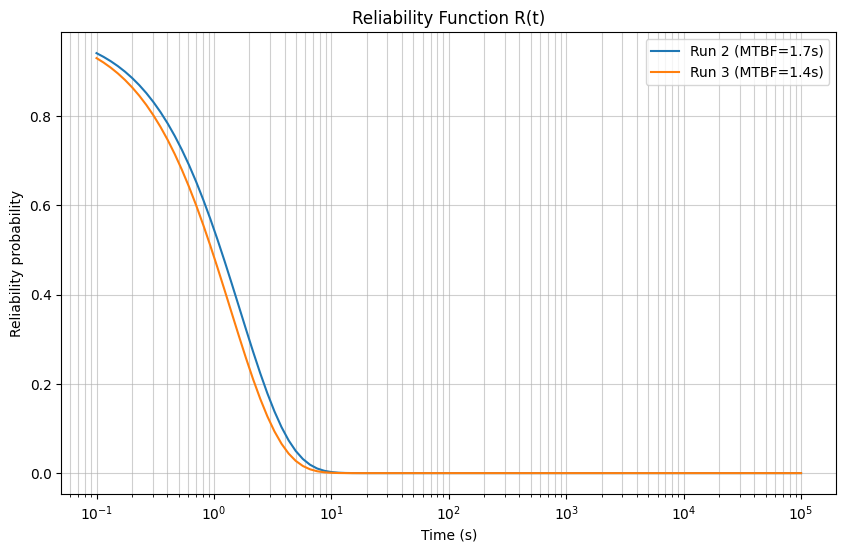

In [7]:
def calculate_metrics(run_name, fails_path, beam_path, window_size_s=0.1):
    print(f"\n--- Processing {run_name} ---")
    
    # 1. Load Data
    fails, beam = load_and_prep_data(fails_path, beam_path)
    
    # 2. Filter for Beam ON
    # Merge to get beam status for each fail
    fails_merged = pd.merge_asof(fails, beam[['time', 'beam_on']], on='time', direction='backward')
    fails_on = fails_merged[fails_merged['beam_on'] == True].copy()
    
    # Filter beam data for Beam ON to calculate fluence and time
    beam_on = beam[beam['beam_on'] == True].copy()
    
    # 3. Calculate Fluence (Phi) and Time
    # We use 'dHEH' column for incremental fluence if available, or diff of cumulative 'HEH'
    if 'dHEH' in beam_on.columns:
        phi_total = beam_on['dHEH'].sum()
    else:
        # Fallback: max - min of cumulative (approximate if contiguous, but beam_on is fragmented)
        # Better to use diff if dHEH not present
        phi_total = beam_on['HEH'].diff().clip(lower=0).sum()
        
    # Calculate Total Time (Beam ON)
    # Sum of 'dt' if available, else diff of time
    if 'dt' in beam_on.columns:
        time_total_s = beam_on['dt'].sum()
    else:
        time_total_s = (beam_on['time'].diff().dt.total_seconds()).fillna(0).sum()
        
    # 4. Calculate Corrected N
    # We need to apply the correction over the entire beam-on period.
    # We can split the data into chunks or just use the occupancy function on the whole set
    # Note: compute_occupancy expects a continuous timeline or handles gaps if we are careful.
    # Here we simply compute occupancy for the filtered fails_on data.
    # Warning: This treats the concatenated beam-on segments as continuous for windowing,
    # which might introduce slight edge effects at boundaries, but is acceptable for large N.
    
    occ = compute_occupancy(fails_on, time_col='time', signal_col='fails_inst', window_size_s=window_size_s)
    res = estimate_rate_occupancy(occ, window_size_s=window_size_s)
    
    lambda_corrected = res['lambda_hat']
    lambda_naive = res['lambda_naive']
    
    # N_corrected = lambda_corrected * time_total_s
    # N_naive = len(fails_on) (or sum of fails_inst)
    n_naive = fails_on['fails_inst'].sum()
    n_corrected = lambda_corrected * time_total_s
    
    # 5. Derived Metrics
    cross_section = n_corrected / phi_total if phi_total > 0 else np.nan
    # Failure rate is lambda_corrected (per second)
    mtbf = 1 / lambda_corrected if lambda_corrected > 0 else np.inf
    
    return {
        'Run': run_name,
        'Time_ON (s)': time_total_s,
        'Fluence_HEH': phi_total,
        'N_Naive': n_naive,
        'N_Corrected': n_corrected,
        'Lambda_Naive (Hz)': lambda_naive,
        'Lambda_Corrected (Hz)': lambda_corrected,
        'Cross_Section (cm^2)': cross_section,
        'MTBF (s)': mtbf
    }

# Run for both datasets
metrics_run2 = calculate_metrics("Run 2", fails_path_run2, beam_path_run2)
metrics_run3 = calculate_metrics("Run 3", fails_path_run3, beam_path_run3)

# Create DataFrame for comparison
df_metrics = pd.DataFrame([metrics_run2, metrics_run3])

# Display
print("\n=== Radiation Study Metrics ===")
print(df_metrics.T)

# Reliability Plot
t = np.logspace(-1, 5, 100) # 0.1s to 100,000s
r2 = np.exp(-metrics_run2['Lambda_Corrected (Hz)'] * t)
r3 = np.exp(-metrics_run3['Lambda_Corrected (Hz)'] * t)

plt.figure(figsize=(10, 6))
plt.semilogx(t, r2, label=f"Run 2 (MTBF={metrics_run2['MTBF (s)']:.1f}s)")
plt.semilogx(t, r3, label=f"Run 3 (MTBF={metrics_run3['MTBF (s)']:.1f}s)")
plt.title('Reliability Function R(t)')
plt.xlabel('Time (s)')
plt.ylabel('Reliability probability')
plt.grid(True, which="both", ls="-", alpha=0.6)
plt.legend()
plt.show()

It is required to calculate the corresponding time inside of the LHC. 
- [ ] Input the resulting equivalence for CHARM-LHC in the different radiation types.

## Bathub corrections
We wish to analyze if we are in the useful area, for this consider